# **Project: Multitask Learning for Geometric Shape Classification and Counting**

## 1. Overview

In this project, you will design, implement, and evaluate a **multitask neural network** that performs **two tasks simultaneously**:

1. **Classification** – identify which pair of geometric shape types appears in a 28×28 binary image (135 possible configurations).
2. **Regression** – predict how many shapes of each type are present (6 regression targets).

This project focuses on **multi-task learning**, i.e., using one shared model to learn several related tasks at once. You will compare how adding an auxiliary task affects performance and training dynamics.

---

---

## 8. Experiments and analysis

You must train and compare **three model settings**:

| Setting | Description                                      |
| :------ | :----------------------------------------------- |
| 1       | **Classification-only:** λ_cnt = 0               |
| 2       | **Regression-only:** classification loss ignored |
| 3       | **Multitask:** λ_cnt = with your choose          |

For each experiment:

* Train until early stopping
* Record loss, accuracy, RMSE, and runtime
* Compare results and explain how λ influences learning
* Discuss whether multitask learning improves the main tasks

---

## 9. Final deliverables

You must submit .zip project with:

1. **Code** (`.ipynb` or `.py`) that:

   * Downloads and extracts the dataset
   * Defines dataset, dataloaders, model, loss, training loop, evaluation, and plotting
   * Can run start-to-end without interaction, and finishes within 30 minutes on Colab T4 GPUs
   * Includes three experiment configurations

2. **Report (2–4 pages, PDF)** including:
   * Section on (EDA) Exploratory Data Analysis in your report: no more than 3 graphs or tables describing the data set.
   * Model architecture
   * Description and justification of augmentations
   * Results table (loss, accuracy, RMSE for all runs)
   * Learning curves
   * Discussion on multitask effects

3. **README.md**:

   * Link to Colab version of task for fast replication.
   * Approximate runtime and resource requirements

---

## 10. Grading rubric

Component	Description	Points
1. Implementation correctness	Correct use of the fixed backbone, two-headed model, and proper training loop (classification + regression).	30%
2. Data & augmentations	Proper dataset loading, preprocessing, and at least three augmentations with brief justification.	20%
3. Evaluation & experiments	Correct computation of metrics (accuracy, F1, RMSE) and completion of all three λ configurations (λ=0, regression-only, your choice λ).	30%
4. Report & analysis
A clear separation of concerns (e.g. headers in notebooks, modules in code) and concise 2–4 page report with results tables, learning curves, confusion matrix, and short discussion on multitask effects and error examples.
20%

###### Readability and modularity will be considered within each grading component. Clear structure (headers in notebooks, docstrings, modular code) significantly improves evaluation speed. Emphasize using clear headers to help reviewers navigate efficiently.
---

Setup
===

In [1]:
# only needs to be run once
# UNCOMMENT THIS IF RUNNING FOR THE FIRST TIME.
!wget  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip

--2025-11-24 18:30:28--  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip [following]
--2025-11-24 18:30:29--  https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘data_gsn.zip’

data_gsn.zip        100%[===================>]   5.29M  --.-KB/s    in 0.05s   

2025-11-24 18:30:29 (117 MB/s) - ‘data_gsn.zip’ saved [5544261/5544261]



In [2]:
!pip3 install pillow torch torchvision

In [3]:
#Run this if you get `valueerror: module functions cannot set METH_CLASS or METH_STATIC`
!pip3 install -U numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 38.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.5 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3

In [4]:
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import tqdm
import PIL as pillow
from torchvision.transforms.functional import pil_to_tensor
import os
import enum

* Optimizer: **Adam**, learning rate = 1e-3
* Epochs: up to **100** (use **early stopping**)
* Batch sizes: **64** (train), **1000** (validation)
* Device: GPU allowed for Notebook, but your **final code must run on GPU within ~30 minutes**
* Random seed: set `torch.manual_seed(1)` for reproducibility
* Split: **exactly 9,000 train / 1,000 validation**

In [5]:
torch.manual_seed(1)
EPOCHS = 100
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_VALIDATION = 1000
TRAIN_SIZE = 9000

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Read and augment the dataset
===

* Reads `labels.csv`
* Loads the corresponding image (from `data/`)
* Returns both:
  * the image (as a tensor)
  * the labels (counts for 6 shapes)

For transformations, a separate class was introduced.

In [7]:
class ImageSize:
  """
  Helper class to contain image size coordinates, for readability.
  """
  def __init__(self, x, y):
    self.x = x
    self.y = y

class Dataset(torch.utils.data.Dataset):

  """
  Dataset class. Handles reading, processing, and augmentation of the input data.
  """
  def __init__(self, path: str, transform=None, verbose: bool = True):
    """
    Initialize the dataset.
    :param path: path to the image folder.
    :param transform: transformations / augmentations to apply to the images.
    :param verbose: enable logging.
    """
    self.path = path
    self.verbose = verbose

    self.y = None
    self.image_data = None
    self.n_images = 0
    self.image_size = None

    self.transform = transform

    self.train = True
    if self.verbose:
      print("Initialized in verbose mode")

  def load(self) -> tuple[list, list]:
    """
    Load data.
    """
    if self.verbose:
      print("Reading all data")

    # Read labels
    if self.verbose:
      print("Reading labels")
    labels = pd.read_csv(os.path.join(self.path,"labels.csv"))
    self.n_images = len(labels)
    if self.verbose:
      print("Labels:")
      print(labels.head())
    names = labels["name"]
    self.y = torch.Tensor(labels[["squares", "circles", "up", "right", "down", "left"]].to_numpy())

    # Read data
    image_size = self.set_image_shape_by_example(names[0])
    self.image_data = torch.zeros((self.n_images, image_size.x * image_size.y)) # initialization

    for i in tqdm.tqdm(range(self.n_images)):
      with open(os.path.join(self.path, names[i]), "rb") as image_file:
        image = pillow.Image.open(image_file).convert('L')
        assert image.width == image_size.x and image.height == image_size.y, "Mismatched image size"

        self.image_data[i] = torchvision.transforms.functional \
                              .pil_to_tensor(image) \
                              .reshape((image_size.x * image_size.y,)) / 255.0

    if self.verbose:
      print(f"Data shape is {self.image_data.shape} ({self.n_images} images of ({self.image_size.x},{self.image_size.y}) size)")

    return self.image_data, self.y

  def __getitem__(self, idx):
    image, label = self.image_data[idx].clone(), self.y[idx].clone()
    if self.transform:
      image, label = self.transform(image, label)
    return image, label

  def __len__(self):
      return self.n_images

  def set_image_shape_by_example(self, image_name) -> ImageSize:
    """
    Set image size field in the class by read a single image from the dataset.
    Needed for later validations.
    :param image_name: path to the image relative to the data folder
    :return: image size
    """
    with open(os.path.join(self.path, image_name), "rb") as image_file:
        image = pillow.Image.open(image_file).convert('L')
        self.image_size = ImageSize(image.width, image.height)
    if self.verbose:
      print(f"Image shape is set to ({self.image_size.x}, {self.image_size.y}) based on {image_name}")
    return self.image_size

dataset = Dataset("data/", transform=None, verbose=True)
dataset.load()
assert dataset.n_images == 10_000
print(dataset.image_data.shape)
print(dataset.y.shape)

Initialized in verbose mode
Reading all data
Reading labels
Labels:
            name  squares  circles  up  right  down  left
0  img_00000.png        0        0   4      0     6     0
1  img_00001.png        0        0   0      5     0     5
2  img_00002.png        0        0   8      0     2     0
3  img_00003.png        0        7   0      0     0     3
4  img_00004.png        0        0   3      0     0     7
Image shape is set to (28, 28) based on img_00000.png


100%|██████████| 10000/10000 [00:05<00:00, 1711.96it/s]

Data shape is torch.Size([10000, 784]) (10000 images of (28,28) size)
torch.Size([10000, 784])
torch.Size([10000, 6])


In [8]:
print(dataset.__getitem__(54)[0].shape, dataset.__getitem__(54)[1].shape)

torch.Size([784]) torch.Size([6])


In [9]:
for idx in [0, 100, 500, 1000, 5000, 9000]:
    label = dataset.y[idx]
    nonzero = (label > 0).sum().item()
    total = label.sum().item()
    print(f"Index {idx}: {label.tolist()}, nonzero={nonzero}, total={total}")

Index 0: [0.0, 0.0, 4.0, 0.0, 6.0, 0.0], nonzero=2, total=10.0
Index 100: [6.0, 0.0, 0.0, 0.0, 4.0, 0.0], nonzero=2, total=10.0
Index 500: [0.0, 7.0, 3.0, 0.0, 0.0, 0.0], nonzero=2, total=10.0
Index 1000: [0.0, 0.0, 0.0, 8.0, 2.0, 0.0], nonzero=2, total=10.0
Index 5000: [5.0, 0.0, 0.0, 0.0, 5.0, 0.0], nonzero=2, total=10.0
Index 9000: [0.0, 0.0, 8.0, 2.0, 0.0, 0.0], nonzero=2, total=10.0


Define augmentations
-----

1. Random horizontal flip
2. Random vertical flip
3. Random 90° rotation (must correctly rotate orientation labels: up → right → down → left)
4. Random brightness/contrast
5. Gaussian noise
6. Random erasing

In [104]:
print(torch.rand(1).item())
print(torch.rand(1).item())
print(torch.rand(1).item())
print(torch.rand(1).item())

0.8211460113525391
0.9446530342102051
0.8260242938995361
0.8941352963447571


In [139]:
class Augmentation:
  """
  Augmentation types. An image can be modified according to one of those augmentations.
  """
  total = 6

  HORIZONTAL_FLIP = 0
  VERTICAL_FLIP = 1
  ROTATION = 2
  GAUSSIAN_NOISE = 3
  JITTER = 4
  ERASING = 5

class Column:
  """
  Label column indices for readability.
  """
  SQUARES = 0
  CIRCLES = 1
  UP = 2
  RIGHT = 3
  DOWN = 4
  LEFT = 5

class AugmentationTransform:
  def __init__(self, data, image_size, augmentation_probabilities: dict[Augmentation, float]):
      self.data = data


      self.augmentations = torch.zeros(size=(Augmentation.total,))
      for augmentation in range(Augmentation.total):
        print(f"Augmentation {augmentation} probability: {augmentation_probabilities.get(augmentation, 0.0)}")
        self.augmentations[augmentation] = augmentation_probabilities.get(augmentation, 0.0)
      self.image_size = image_size
      self.jitter = torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2)
      self.eraser = torchvision.transforms.RandomErasing(scale=(0.03, 0.06))
      self.gaussian_noise_level = 0.1

  def __call__(self, image, label):
      return self.augment_item(image.clone(), label.clone())

  def augment_item(self, image, label) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Randomly apply augmentations with a given probability each.
    """
    probs = torch.rand(6)
    if probs[0] < self.augmentations[Augmentation.HORIZONTAL_FLIP]:
      image, label = self.augmentation_flip(image, label, Augmentation.HORIZONTAL_FLIP)

    if probs[1] < self.augmentations[Augmentation.VERTICAL_FLIP]:
      image, label = self.augmentation_flip(image, label, Augmentation.VERTICAL_FLIP)

    if probs[2] < self.augmentations[Augmentation.ROTATION]:
      image, label = self.augmentation_rotation(image, label)

    if probs[3] < self.augmentations[Augmentation.GAUSSIAN_NOISE]:
      image, label = self.augmentation_gaussian(image, label, noise_level=self.gaussian_noise_level)

    if probs[4] < self.augmentations[Augmentation.JITTER]:
      image, label = self.augmentation_jitter(image, label)

    if probs[5] < self.augmentations[Augmentation.ERASING]:
      image, label = self.augmentation_erasing(image, label)
    return image, label

  def augmentation_flip(self, image: torch.Tensor, label: torch.Tensor, flip_direction: Augmentation) -> tuple:
    """
    Flip a subset of dataset images in-place.
    :param image: image data
    :param label: label data
    :param flip_direction: either horizontally or vertically
    :return: None
    """
    assert flip_direction == Augmentation.HORIZONTAL_FLIP or Augmentation.VERTICAL_FLIP, "Invalid flip direction"

    #alias for readability
    horizontal = (flip_direction == Augmentation.HORIZONTAL_FLIP)

    # flip
    image_shaped = image.reshape((self.image_size.x, self.image_size.y))
    if horizontal:
      image_flipped = torch.flip(image_shaped, dims=(1,)) # only the horizontal
    else: # vertical
      image_flipped = torch.flip(image_shaped, dims=(0,))
    image = image_flipped.reshape((self.image_size.x * self.image_size.y,))

    new_label = label.clone()
    # relabel
    if horizontal:
      new_label[Column.LEFT], new_label[Column.RIGHT] = label[Column.RIGHT], label[Column.LEFT]
    else: # vertical
      new_label[Column.UP], new_label[Column.DOWN] = label[Column.DOWN], label[Column.UP]
    return image, new_label

  def augmentation_rotation(self, image: torch.Tensor, label: torch.Tensor) -> tuple:
    """
    Rotate image either clockwise or counterclockwise with 50/50 probability.
    :param image: image data
    :param label: label data
    :return: tuple (image, label)
    """
    image_shaped = image.reshape((self.image_size.x, self.image_size.y))

    new_label = label.clone()
    clockwise = torch.randint(0, 2, size=(1,))[0] < 0.5
    if clockwise:
      image_rotated = torch.rot90(image_shaped, k=1, dims=(0, 1))
      new_label[Column.UP], new_label[Column.RIGHT], new_label[Column.DOWN], new_label[Column.LEFT] = \
        label[Column.LEFT], label[Column.UP], label[Column.RIGHT], label[Column.DOWN]
    else:
      image_rotated = torch.rot90(image_shaped, k=-1, dims=(0, 1))
      new_label[Column.UP], new_label[Column.LEFT], new_label[Column.DOWN], new_label[Column.RIGHT] = \
        label[Column.RIGHT], label[Column.UP], label[Column.LEFT], label[Column.DOWN]

    image = image_rotated.reshape((self.image_size.x * self.image_size.y,))
    return image, new_label

  def augmentation_gaussian(self, image: torch.Tensor, label: torch.Tensor, noise_level: float) -> tuple:
    """
    Add Gaussian noise to image.
    :param image: image data
    :param label: label data (unchanged)
    :param noise_level: pixel value variance
    :return: tuple (image, label)
    """
    noise = torch.normal(0., 1., size=image.shape)
    image = image + noise_level * noise
    image = torch.clamp(image, 0, 1)
    return image, label

  def augmentation_jitter(self, image: torch.Tensor, label: torch.Tensor) -> tuple:
    """
    Add random brightness/contrast changes to the image.
    :param image: image data
    :param label: label data (unchanged)
    :return: tuple (image, label)
    """
    image_shaped = image.reshape((1, self.image_size.x, self.image_size.y))
    image_jittered = self.jitter(image_shaped)
    image = image_jittered.reshape((self.image_size.x * self.image_size.y,))
    return image, label

  def augmentation_erasing(self, image: torch.Tensor, label: torch.Tensor) -> tuple:
    """
    Erase a random part of the image.
    :param image: image data
    :param label: label data (unchanged)
    :return: tuple (image, label)
    """
    image_shaped = image.reshape((1, self.image_size.x, self.image_size.y))
    imaged_erased = self.eraser(image_shaped)
    image = imaged_erased.reshape((self.image_size.x * self.image_size.y,))
    return image, label

Verify dataset and augmentation
----

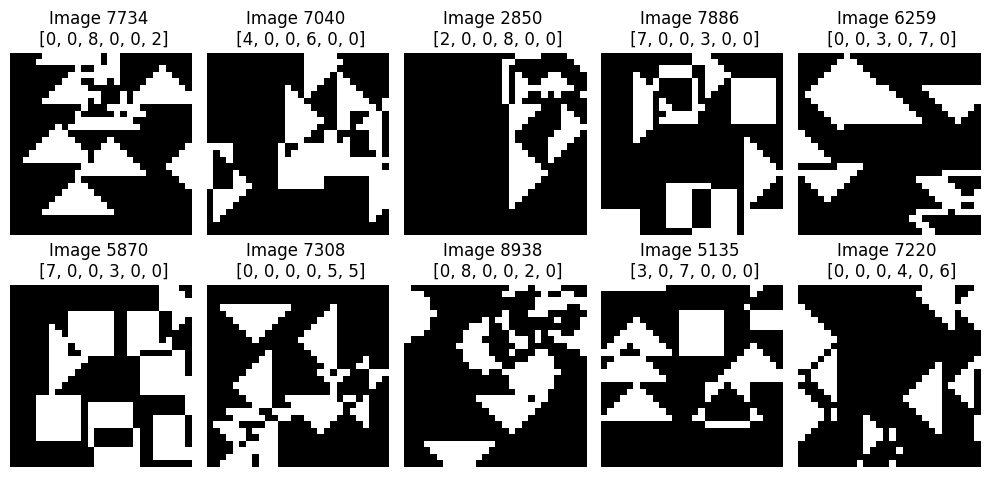

In [47]:
import matplotlib.pyplot as plt
import random

random_indices = random.sample(range(dataset.n_images), 10)

plt.figure(figsize=(10, 5))
for i, index in enumerate(random_indices):
    image_data = dataset.image_data[index].reshape((dataset.image_size.y, dataset.image_size.x))
    label = list([int(k) for k in dataset.y[index]])
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_data.numpy(), cmap='gray')
    plt.title(f"Image {index} \n {label}")
    plt.axis('off')

plt.tight_layout()
plt.savefig("dataset_example_nonaugmented.jpg")
plt.show()

Augmentation 0 probability: 0.5
Augmentation 1 probability: 0.5
Augmentation 2 probability: 0.5
Augmentation 3 probability: 0.2
Augmentation 4 probability: 0.5
Augmentation 5 probability: 0.5


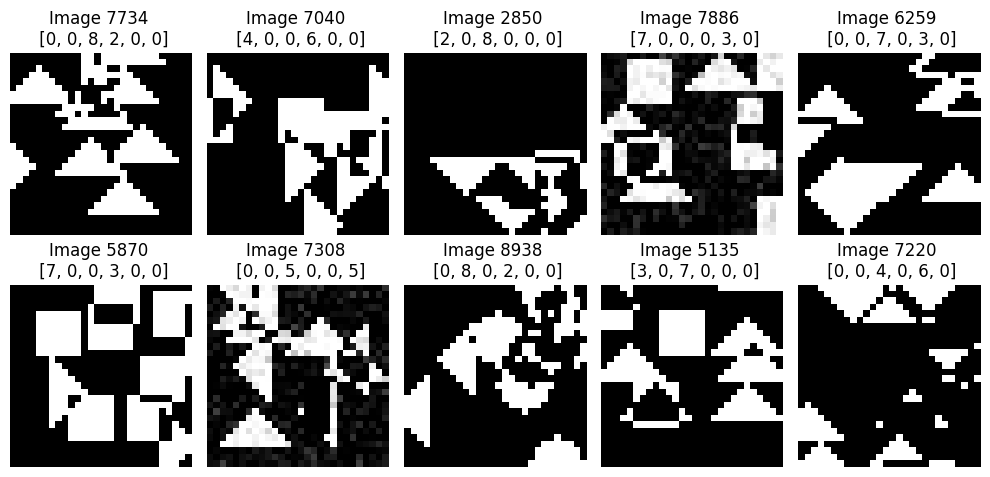

In [140]:
transform = AugmentationTransform(dataset,
                                  dataset.image_size,
                             {Augmentation.HORIZONTAL_FLIP: 0.5,
                              Augmentation.VERTICAL_FLIP: 0.5,
                              Augmentation.ROTATION: 0.5,
                              Augmentation.GAUSSIAN_NOISE: 0.2,
                              Augmentation.JITTER: 0.5,
                              Augmentation.ERASING: 0.5})

plt.figure(figsize=(10, 5))
for i, index in enumerate(random_indices):
    sample_image, sample_label = dataset.image_data[index], dataset.y[index]
    sample_image_augmented, sample_label_augmented = transform(sample_image, sample_label)
    image_data = sample_image_augmented.reshape((dataset.image_size.y, dataset.image_size.x))
    label = list([int(k) for k in sample_label_augmented])
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_data.numpy(), cmap='gray')
    plt.title(f"Image {index} \n {label}")
    plt.axis('off')

plt.tight_layout()
plt.savefig("dataset_example_augmented.jpg")
plt.show()

In [13]:
sample_indices = [0, 100, 500, 1000, 5000]
for idx in sample_indices:
    label = dataset.y[idx]
    nonzero_count = (label > 0).sum().item()
    total = label.sum().item()
    print(f"Index {idx}: {label.tolist()}, nonzero={nonzero_count}, sum={total}")

Index 0: [0.0, 0.0, 4.0, 0.0, 6.0, 0.0], nonzero=2, sum=10.0
Index 100: [6.0, 0.0, 0.0, 0.0, 4.0, 0.0], nonzero=2, sum=10.0
Index 500: [0.0, 7.0, 3.0, 0.0, 0.0, 0.0], nonzero=2, sum=10.0
Index 1000: [0.0, 0.0, 0.0, 8.0, 2.0, 0.0], nonzero=2, sum=10.0
Index 5000: [5.0, 0.0, 0.0, 0.0, 5.0, 0.0], nonzero=2, sum=10.0


Set up the model
===

1. **Classifies** each image into one of **135 possible configurations**, representing:

   * which **two shape classes** appear, and
   * how their counts (1–9) sum to 10.

   → Example: "3 circles + 7 squares" is one configuration class.

2. **Regresses** the number of shapes of each type (a 6-dimensional real-valued output).

3. Combines both objectives in a **joint loss** function (Hint: losses are implemented in PyTorch):


$$ Loss = \text{NLLLoss(classification)} + \lambda_{\text{cnt}} \cdot \text{SmoothL1Loss(regression)} $$

In [14]:
class ShapeType(enum.Enum):
    """
    Figure shape classes.
    """
    SQUARE = 0
    CIRCLE = 1
    TRIANGLE_UP = 2
    TRIANGLE_RIGHT = 3
    TRIANGLE_DOWN = 4
    TRIANGLE_LEFT = 5

In [15]:
n_shape_classes = torch.combinations(torch.arange(len(ShapeType)), r=2)
n_figures = 10

output_classes = torch.cat((n_shape_classes.repeat_interleave(n_figures - 1, dim=0), torch.arange(1, n_figures).repeat(len(n_shape_classes)).view(-1, 1)), dim=1)
print(len(output_classes))
assert len(output_classes) == 135
# output_classes_dict = {tuple(output_class.tolist()): i for i, output_class in enumerate(output_classes)}
# print(output_classes_dict.keys())

135


In [16]:
lookup = torch.full((6, 6, 10), -1, dtype=torch.long).to(device)
for idx, (s1, s2, c1) in enumerate(output_classes):
    lookup[int(s1), int(s2), int(c1)] = idx

def shapes_to_output_class(y):
    """
    Converts from counts vector to class index.

    :param y: (batch, 6) or (6,) tensor of counts
    :return: (batch,) or scalar tensor of class indices
    """
    if y.dim() == 1:
        y = y.unsqueeze(0)
        return shapes_to_output_class(y).squeeze()

    batch_size = y.shape[0]

    nonzero_indices = (y > 0).nonzero()
    shape_indices = nonzero_indices[:, 1].view(batch_size, 2)

    shape1 = shape_indices[:, 0]
    shape2 = shape_indices[:, 1]
    count1 = y[torch.arange(batch_size), shape1].to(torch.int32)

    return lookup[shape1, shape2, count1]

print(shapes_to_output_class(torch.Tensor([[3, 0, 7, 0, 0, 0], [0, 0, 0, 8, 0, 2]])))

tensor([ 11, 124], device='cuda:0')


### Architecture constraints
```python
nn.Sequential(
    nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(64 * 28 * 28, 256), nn.ReLU()
)
```

**two separate heads**:

* `head_cls`: outputs log-probabilities for 135 classes
* `head_cnt`: outputs 6 regression values (counts)

The model must return two outputs: `(log_probs, counts)`.

In [17]:
class ShapeClassifier(nn.Module):
    @staticmethod
    def create_feature_extractor():
        feature_extractor = torch.nn.Sequential(
        nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
        nn.Flatten(start_dim=1),
        nn.Linear(64 * 28 * 28, 256), nn.ReLU())

        return feature_extractor

    def __init__(self, optimizer=torch.optim.Adam, lr=1e-3, epochs=100, batch_size=64, batch_size_val=1000, loss_coef=1):
        super().__init__()
        self.optimizer = optimizer
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.batch_size_val = batch_size_val

        self.loss_normalization_coef = loss_coef

        self.feature_extractor = self.create_feature_extractor()
        self.head_shapes = nn.Sequential(nn.Linear(256, 135))
        self.head_counts = nn.Sequential(nn.Linear(256, 6))

    def loss(self, logits_cls, target_shape, logits_counts, target_counts):
        return (torch.nn.functional.nll_loss(torch.log_softmax(logits_cls, dim=1), target_shape, reduction='mean') +
                self.loss_normalization_coef * torch.nn.functional.smooth_l1_loss(logits_counts, target_counts))

    def forward(self, x):
        features = self.feature_extractor(x)
        logits_cls = self.head_shapes(features)
        logits_counts = self.head_counts(features)
        return logits_cls, logits_counts


In [18]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

Load data
====

In [132]:
n_images = dataset.n_images
split_point = int(TRAIN_SIZE)

train_transform = AugmentationTransform(dataset,
                                  dataset.image_size,
                             {Augmentation.HORIZONTAL_FLIP: 0.5,
                              Augmentation.VERTICAL_FLIP: 0.5,
                              Augmentation.ROTATION: 0.25,
                              Augmentation.GAUSSIAN_NOISE: 0.2,
                              Augmentation.JITTER: 0.5,
                              Augmentation.ERASING: 0.4})
train_dataset = Dataset("data/", transform=train_transform, verbose=True)
# train_dataset = Dataset("data/", transform=None, verbose=True)
train_dataset.load()
train_subset = torch.utils.data.Subset(train_dataset, list(range(TRAIN_SIZE)))

test_dataset = Dataset("data/", transform=None, verbose=False)
test_dataset.image_data = train_dataset.image_data  # Share memory
test_dataset.y = train_dataset.y
test_dataset.n_images = train_dataset.n_images
test_dataset.image_size = train_dataset.image_size
test_subset = torch.utils.data.Subset(test_dataset, list(range(TRAIN_SIZE, n_images)))

Augmentation 0 probability: 0.5
Augmentation 1 probability: 0.5
Augmentation 2 probability: 0.25
Augmentation 3 probability: 0.2
Augmentation 4 probability: 0.5
Augmentation 5 probability: 0.4
Initialized in verbose mode
Reading all data
Reading labels
Labels:
            name  squares  circles  up  right  down  left
0  img_00000.png        0        0   4      0     6     0
1  img_00001.png        0        0   0      5     0     5
2  img_00002.png        0        0   8      0     2     0
3  img_00003.png        0        7   0      0     0     3
4  img_00004.png        0        0   3      0     0     7
Image shape is set to (28, 28) based on img_00000.png


100%|██████████| 10000/10000 [00:03<00:00, 3021.95it/s]

Data shape is torch.Size([10000, 784]) (10000 images of (28,28) size)


In [133]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=BATCH_SIZE_VALIDATION, shuffle=False)

In [21]:
print(f"Train loader size: {len(train_loader.dataset)}")
print(f"Test loader size: {len(test_loader.dataset)}")

Train loader size: 9000
Test loader size: 1000


In [22]:
for i in range(5):
    label = dataset.y[i]
    class_idx = shapes_to_output_class(label)
    print(f"Label: {label.tolist()} → Class: {class_idx.item()}")
    print(f"Should be: {output_classes[class_idx]}")

Label: [0.0, 0.0, 4.0, 0.0, 6.0, 0.0] → Class: 93
Should be: tensor([2, 4, 4])
Label: [0.0, 0.0, 0.0, 5.0, 0.0, 5.0] → Class: 121
Should be: tensor([3, 5, 5])
Label: [0.0, 0.0, 8.0, 0.0, 2.0, 0.0] → Class: 97
Should be: tensor([2, 4, 8])
Label: [0.0, 7.0, 0.0, 0.0, 0.0, 3.0] → Class: 78
Should be: tensor([1, 5, 7])
Label: [0.0, 0.0, 3.0, 0.0, 0.0, 7.0] → Class: 101
Should be: tensor([2, 5, 3])


In [23]:
# Check if all 135 classes exist
from collections import Counter

class_counts = Counter()
for labels in dataset.y:
    class_idx = shapes_to_output_class(labels.unsqueeze(0)).item()
    class_counts[class_idx] += 1

print(f"Classes in dataset: {len(class_counts)}/135")
print(f"Missing classes: {set(range(135)) - set(class_counts.keys())}")
print(f"Most common classes: {class_counts.most_common(10)}")

Classes in dataset: 105/135
Missing classes: {0, 134, 8, 9, 17, 18, 26, 27, 35, 36, 44, 45, 53, 54, 62, 63, 71, 72, 80, 81, 89, 90, 98, 99, 107, 108, 116, 117, 125, 126}
Most common classes: [(59, 120), (92, 115), (97, 112), (88, 112), (85, 109), (5, 108), (121, 107), (23, 107), (76, 107), (113, 106)]


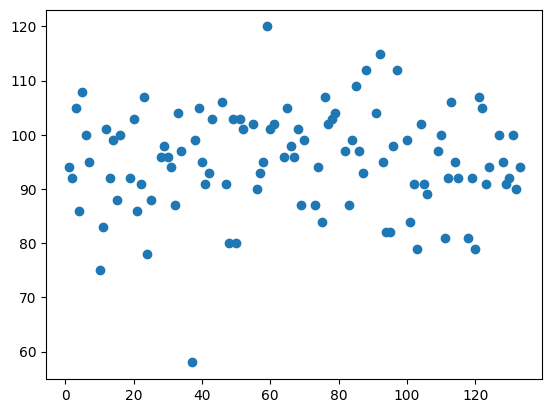

In [171]:
plt.scatter(class_counts.keys(), class_counts.values())
plt.show()

Train the model
===

--

In [179]:
model = ShapeClassifier(loss_coef=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
early_stopping = EarlyStopping(patience=10, delta=0.01)
model

ShapeClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=50176, out_features=256, bias=True)
    (10): ReLU()
  )
  (head_shapes): Sequential(
    (0): Linear(in_features=256, out_features=135, bias=True)
  )
  (head_counts): Sequential(
    (0): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [ ]:
from collections import Counter
image_size = dataset.image_size

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm.tqdm(train_loader):
        images = images.view(-1, 1, image_size.x, image_size.y).to(device)
        labels = labels.to(device)

        cls_goal = shapes_to_output_class(labels)
        cnt_goal = labels

        cls_y, cnt_y = model(images)

        loss = model.loss(cls_y, cls_goal, cnt_y, cnt_goal)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_predictions = cls_y.argmax(dim=1)
        train_correct += (train_predictions == cls_goal).sum().item()
        train_total += labels.size(0)

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 1, 28, 28).to(device)
            labels = labels.to(device)

            target_counts = labels
            target_shape = shapes_to_output_class(labels)

            logits_cls, logits_counts = model(images)
            loss = model.loss(logits_cls, target_shape, logits_counts, target_counts)

            test_loss += loss.item()

            # Accuracy
            predictions = logits_cls.argmax(dim=1)
            correct += (predictions == target_shape).sum().item()
            total += labels.size(0)

    cls_loss = torch.nn.functional.cross_entropy(logits_cls, target_shape)
    reg_loss = torch.nn.functional.smooth_l1_loss(logits_counts, target_counts)
    sum_loss = cls_loss + model.loss_normalization_coef * reg_loss

    print(f"Cls: {cls_loss:.4f} | Reg: {reg_loss:.4f} | Total: {sum_loss:.4f}")
    print(f"Epoch {epoch+1}/{model.epochs} | "
          f"Train Loss: {total_loss/len(train_loader):.4f} | "
          f"Test Loss: {test_loss/len(test_loader):.4f} | "
          f"Train Acc: {100*train_correct/train_total:.2f}% | "
          f"Test Acc: {100*correct/total:.2f}%")
    predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            logits_cls, _ = model(images.view(-1, 1, 28, 28).to(device))
            predictions.extend(logits_cls.argmax(dim=1).cpu().tolist())

    early_stopping(sum_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

early_stopping.load_best_model(model)

100%|██████████| 141/141 [00:18<00:00,  7.83it/s]


Cls: 4.2644 | Reg: 1.1594 | Total: 11.2207
Epoch 1/100 | Train Loss: 13.0396 | Test Loss: 11.2207 | Train Acc: 1.30% | Test Acc: 2.70%


100%|██████████| 141/141 [00:17<00:00,  8.07it/s]


Cls: 2.9004 | Reg: 0.7105 | Total: 7.1631
Epoch 2/100 | Train Loss: 9.5651 | Test Loss: 7.1631 | Train Acc: 8.87% | Test Acc: 13.90%


100%|██████████| 141/141 [00:17<00:00,  7.85it/s]


Cls: 2.3370 | Reg: 0.5027 | Total: 5.3532
Epoch 3/100 | Train Loss: 6.8308 | Test Loss: 5.3532 | Train Acc: 20.41% | Test Acc: 22.30%


100%|██████████| 141/141 [00:17<00:00,  8.20it/s]


Cls: 2.1203 | Reg: 0.4270 | Total: 4.6824
Epoch 4/100 | Train Loss: 5.3887 | Test Loss: 4.6824 | Train Acc: 29.82% | Test Acc: 23.80%


 28%|██▊       | 40/141 [00:04<00:12,  8.37it/s]

Evaluate the model
===

Implement and report the following metrics on the validation set:

### (a) **Classification (135-way)**

* Top-1 accuracy
* Macro F1-score
* Per-pair accuracy (aggregate by unordered shape pair, e.g. {circle, up})

### (b) **Regression (6-D counts)**

* RMSE per class and overall
* MAE per class and overall

Also plot:

* Training and validation losses
* Validation accuracy and RMSE over epochs

**Important**: This task is not about finding the best architecture; we expect at least 50% accuracy, but achieving results higher than that will not affect the grade for the assignment**.


Analyze the failure modes
---

In [143]:
def analyze_features():
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 1, 28, 28).to(device)
            features = model.feature_extractor(images)
            all_features.append(features.cpu())
            all_labels.append(labels)

    features = torch.cat(all_features)
    labels = torch.cat(all_labels)

    # Check feature statistics
    print(f"Feature mean: {features.mean():.4f}")
    print(f"Feature std: {features.std():.4f}")
    print(f"Dead neurons (std < 0.01): {(features.std(dim=0) < 0.01).sum()}/256")
    print(f"Feature rank (approx): {torch.linalg.matrix_rank(features[:1000])}/256")

analyze_features()

Feature mean: 0.9088
Feature std: 2.4056
Dead neurons (std < 0.01): 168/256
Feature rank (approx): 88/256


In [144]:
def analyze_predictions():
    model.eval()
    shape_correct = 0
    count_correct = 0
    both_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 1, 28, 28).to(device)
            labels = labels.to(device)

            logits_cls, _ = model(images)
            preds = logits_cls.argmax(dim=1)
            targets = shapes_to_output_class(labels)

            for i in range(len(preds)):
                pred_class = output_classes[preds[i]]
                true_class = output_classes[targets[i]]

                # Check if shape types match (first two elements)
                if pred_class[0] == true_class[0] and pred_class[1] == true_class[1]:
                    shape_correct += 1

                # Check if count matches (third element)
                if pred_class[2] == true_class[2]:
                    count_correct += 1

                if preds[i] == targets[i]:
                    both_correct += 1

                total += 1

    print(f"Shape pair accuracy: {100*shape_correct/total:.2f}%")
    print(f"Count accuracy: {100*count_correct/total:.2f}%")
    print(f"Both correct: {100*both_correct/total:.2f}%")
    print(f"\nIf independent: {100*(shape_correct/total)*(count_correct/total):.2f}%")

analyze_predictions()

Shape pair accuracy: 86.40%
Count accuracy: 34.70%
Both correct: 29.00%

If independent: 29.98%


In [145]:
# Analyze errors by shape pair
from collections import defaultdict

errors_by_shapes = defaultdict(list)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 1, 28, 28).to(device)
        labels = labels.to(device)

        logits_cls, _ = model(images)
        preds = logits_cls.argmax(dim=1)
        targets = shapes_to_output_class(labels)

        for i in range(len(preds)):
            if preds[i] != targets[i]:
                # Get which shapes are in this sample
                true_class = output_classes[targets[i]]
                pred_class = output_classes[preds[i]]
                shapes = (int(true_class[0]), int(true_class[1]))
                errors_by_shapes[shapes].append((true_class, pred_class))

# Find shape pairs with most errors
for shapes, errors in sorted(errors_by_shapes.items(), key=lambda x: len(x[1]), reverse=True)[:5]:
    print(f"\nShape pair {shapes}: {len(errors)} errors")
    print(f"Example errors: {errors[:3]}")


Shape pair (1, 3): 57 errors
Example errors: [(tensor([1, 3, 3]), tensor([1, 3, 2])), (tensor([1, 3, 2]), tensor([1, 3, 4])), (tensor([1, 3, 7]), tensor([1, 3, 5]))]

Shape pair (1, 2): 55 errors
Example errors: [(tensor([1, 2, 7]), tensor([1, 2, 8])), (tensor([1, 2, 7]), tensor([1, 2, 8])), (tensor([1, 2, 7]), tensor([1, 2, 5]))]

Shape pair (4, 5): 54 errors
Example errors: [(tensor([4, 5, 7]), tensor([4, 5, 5])), (tensor([4, 5, 3]), tensor([4, 5, 4])), (tensor([4, 5, 5]), tensor([4, 5, 6]))]

Shape pair (0, 2): 53 errors
Example errors: [(tensor([0, 2, 5]), tensor([0, 2, 3])), (tensor([0, 2, 5]), tensor([0, 2, 7])), (tensor([0, 2, 2]), tensor([2, 4, 8]))]

Shape pair (0, 5): 51 errors
Example errors: [(tensor([0, 5, 6]), tensor([0, 5, 4])), (tensor([0, 5, 8]), tensor([0, 1, 8])), (tensor([0, 5, 8]), tensor([0, 1, 8]))]
